<a href="https://colab.research.google.com/github/prashanth018/Text-Summarization/blob/Dyuthi/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import io
import re
import spacy
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import files
uploaded = files.upload()

Saving news_category_dataset-161000-171000.csv to news_category_dataset-161000-171000 (2).csv


In [6]:
dataset = pd.read_csv(io.BytesIO(uploaded[r'news_category_dataset-161000-171000.csv']))
dataset

,Unnamed: 0,news_text,category,headline,short_desc,url
0,1,This undated publicity film image provided by ...,ENTERTAINMENT,Entertainment vs. Historical Accuracy?,A filmmaker who seeks to portray major events ...,https://www.huffingtonpost.com/entry/entertain...
1,2,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",ENTERTAINMENT,The Easter Bunny And 11 Other Famous Rabbits I...,"March 31 marks Easter Sunday, and with it come...",https://www.huffingtonpost.com/entry/the-easte...
2,3,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,ENVIRONMENT,"Animal Photos Of The Week: Lemurs, Lions, Monk...",Here’s a recap of animal stories and events fr...,https://www.huffingtonpost.com/entry/animal-ph...
3,4,* Melted ice re-freezes faster than sea water ...,ENVIRONMENT,Antarctica Melting Brings Expanded Sea Ice Ext...,"WINDS At a winter maximum in September, ice on...",https://www.huffingtonpost.com/entry/antarctic...
4,5,Co-written by Pushker Kharecha and Makiko Sato...,ENVIRONMENT,Doubling Down on Our Faustian Bargain,Humanity's Faustian climate bargain is well kn...,https://www.huffingtonpost.com/entry/doubling-...
...,...,...,...,...,...,...
9995,9996,Last week I shared how I was able to get off c...,WELLNESS,Change Is Easy... When You Want It,Before you start making lofty resolutions that...,https://www.huffingtonpost.com/entry/new-year-...
9996,9997,"""It is not true that money can't buy happiness...",WELLNESS,10 Tricks to Avoid Utter Misery This Holiday S...,Be happy with what you have instead of allowin...,https://www.huffingtonpost.com/entry/holiday-s...
9997,9998,"Even if you don't, there's no need to be afrai...",FOOD & DRINK,5 Seriously Spicy Cocktails,Do you love hot sauce? Sriracha? Chile peppers...,https://www.huffingtonpost.com/entry/spicy-coc...
9998,9999,After stumbling across this peculiar Check You...,HOME & LIVING,11 Most Inappropriate Christmas Ornaments We'v...,"This might be almost NSFW thanks to ""pornaments.""",https://www.huffingtonpost.com/entry/inappropr...


In [7]:
df = pd.DataFrame()
df['news_text'] = dataset['news_text']
df['headline'] = dataset['headline']
df

,news_text,headline
0,This undated publicity film image provided by ...,Entertainment vs. Historical Accuracy?
1,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",The Easter Bunny And 11 Other Famous Rabbits I...
2,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Lemurs, Lions, Monk..."
3,* Melted ice re-freezes faster than sea water ...,Antarctica Melting Brings Expanded Sea Ice Ext...
4,Co-written by Pushker Kharecha and Makiko Sato...,Doubling Down on Our Faustian Bargain
...,...,...
9995,Last week I shared how I was able to get off c...,Change Is Easy... When You Want It
9996,"""It is not true that money can't buy happiness...",10 Tricks to Avoid Utter Misery This Holiday S...
9997,"Even if you don't, there's no need to be afrai...",5 Seriously Spicy Cocktails
9998,After stumbling across this peculiar Check You...,11 Most Inappropriate Christmas Ornaments We'v...


In [8]:
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [9]:
processed_text = text_strip(df['news_text'])
processed_summary = text_strip(df['headline'])
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [10]:
df['cleaned_news_text'] = pd.Series(text)
df['cleaned_headline'] = pd.Series(summary)

In [11]:
df

,news_text,headline,cleaned_news_text,cleaned_headline
0,This undated publicity film image provided by ...,Entertainment vs. Historical Accuracy?,this undated publicity film image provided by ...,_START_ entertainment vs historical accuracy ...
1,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",The Easter Bunny And 11 Other Famous Rabbits I...,washington united states the easter bunny wave...,_START_ the easter bunny and 11 other famous r...
2,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Lemurs, Lions, Monk...",1 712 animal photos of the week 9/16-9/22 yant...,_START_ animal photos of the week lemurs lions...
3,* Melted ice re-freezes faster than sea water ...,Antarctica Melting Brings Expanded Sea Ice Ext...,melted ice re-freezes faster than sea water i...,_START_ antarctica melting brings expanded sea...
4,Co-written by Pushker Kharecha and Makiko Sato...,Doubling Down on Our Faustian Bargain,co-written by pushker kharecha and makiko sato...,_START_ doubling down on our faustian bargain ...
...,...,...,...,...
9995,Last week I shared how I was able to get off c...,Change Is Easy... When You Want It,last week shared how was able to get off coffe...,_START_ change is easy when you want it _END_
9996,"""It is not true that money can't buy happiness...",10 Tricks to Avoid Utter Misery This Holiday S...,it is not true that money can buy happiness i...,_START_ 10 tricks to avoid utter misery this h...
9997,"Even if you don't, there's no need to be afrai...",5 Seriously Spicy Cocktails,even if you don there no need to be afraid in ...,_START_ 5 seriously spicy cocktails _END_
9998,After stumbling across this peculiar Check You...,11 Most Inappropriate Christmas Ornaments We'v...,after stumbling across this peculiar check you...,_START_ 11 most inappropriate christmas orname...


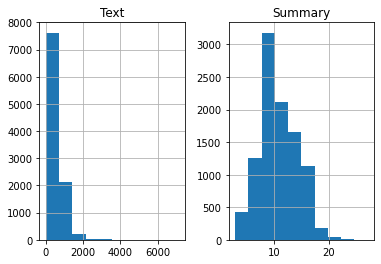

In [12]:
text_count = []
summary_count = []
for sent in df['cleaned_news_text']:
  text_count.append(len(sent.split()))
for sent in df['cleaned_headline']:
  summary_count.append(len(sent.split()))
graph = pd.DataFrame()
graph['Text'] = text_count
graph['Summary'] = summary_count
graph.hist(bins=10)
plt.show()

In [13]:
cnt = 0
for sent in df['cleaned_news_text']:
  if len(sent.split())<=1500:
    cnt=cnt+1
print(cnt/len(df['cleaned_news_text']))

0.9781


In [14]:
max_text_len = 1500
max_summary_len = 20

In [15]:
cleaned_text = np.array(df['cleaned_news_text'])
cleaned_summary= np.array(df['cleaned_headline'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,this undated publicity film image provided by ...,_START_ entertainment vs historical accuracy ...
1,washington united states the easter bunny wave...,_START_ the easter bunny and 11 other famous r...


In [16]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,this undated publicity film image provided by ...,sostok _START_ entertainment vs historical acc...
1,washington united states the easter bunny wave...,sostok _START_ the easter bunny and 11 other f...


In [17]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [18]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.27332911173795


In [19]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 26215


In [20]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 80.36929817698145
Size of vocabulary in Y = 2510


In [21]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [22]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [23]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 200)    5243000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1500, 300),  601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [24]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
